# **Практическое задание**

1. Попробуйте улучшить точность распознавания образов cifar 10 сверточной нейронной
сетью, рассмотренной на уроке. Приложите анализ с описанием того, что улучшает
работу нейронной сети, а что ухудшает
2. Опишите в анализе, какие изменения необходимо было бы внести в получившуюся
нейронную сеть, если бы ей нужно было работать не с cifar10, а с MNIST, CIFAR100 и
IMAGENET

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Activation, Flatten
from tensorflow import keras 
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist
from keras.utils import np_utils

# from tensorflow.keras import models, layers


In [8]:
# Вспомогательные функции

# Фиксирование случайных значений
def randomstate(seed=42):
  np.random.seed(seed)
  tf.random.set_seed(seed)

# Построение графика для изображения
def plot_image(i, predictions_array, true_label, img, labels_name):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(labels_name[predicted_label],
                                100*np.max(predictions_array),
                                labels_name[true_label]),
                                color=color)
  
# Построение графика для визуализации правильных ответов с определенной вероятностью для изображений
def plot_value_array(i, predictions_array, true_label, len_labels):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(len_labels))
  plt.yticks([])
  thisplot = plt.bar(range(len_labels), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### **1. Модель с другими параметрами**

In [9]:
# установка параметров нейросети
batch_size = 128
num_classes = 10
epochs = 5
data_augmentation = True
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [10]:
# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

170508288/170498071 [==============================] - 3s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [11]:
def plot_images(images, labels):
  fig, axes = plt.subplots(1, len(images), figsize = (10, 5))
  for im, l, ax in zip(images, labels, axes):
    ax.imshow(im.reshape(32, 32, 3))
    ax.set_title(l.argmax())

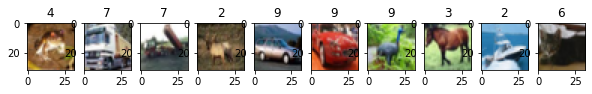

In [12]:
plot_images(x_train[:10], y_train[10:20])

In [13]:
# генерация новых чуть искаженных картинок
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

In [14]:
# datagen[0]

In [15]:
# превращение в итерируемый объект
dg = datagen.flow(x_train[:5], batch_size=1)

In [16]:
# dg[0]

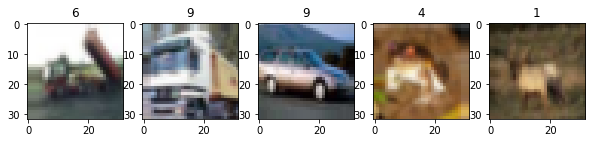

In [17]:
plot_images(dg, y_train[:5])

In [18]:
# конфигурирование слоев нейросети
randomstate()
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(128, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


In [19]:
# инициализация RMSprop optimizer
# opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
opt = keras.optimizers.RMSprop(learning_rate=0.001, decay=1e-6)

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [20]:
# запуск data augmentation через fit_generator
model.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=batch_size),
                    # epochs=epochs,
                    epochs=10,
                    validation_data=(x_test, y_test))


# Исходная точность модели
# Epoch 1/5
# 391/391 [==============================] - 24s 56ms/step - loss: 1.9914 - accuracy: 0.2637 - val_loss: 1.7152 - val_accuracy: 0.3934
# Epoch 2/5
# 391/391 [==============================] - 21s 54ms/step - loss: 1.7263 - accuracy: 0.3677 - val_loss: 1.5726 - val_accuracy: 0.4284
# Epoch 3/5
# 391/391 [==============================] - 21s 55ms/step - loss: 1.6253 - accuracy: 0.4058 - val_loss: 1.4719 - val_accuracy: 0.4672
# Epoch 4/5
# 391/391 [==============================] - 22s 56ms/step - loss: 1.5474 - accuracy: 0.4350 - val_loss: 1.3793 - val_accuracy: 0.5010
# Epoch 5/5
# 391/391 [==============================] - 22s 55ms/step - loss: 1.4994 - accuracy: 0.4578 - val_loss: 1.3582 - val_accuracy: 0.5093

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


391/391 [==============================] - 36s 59ms/step - loss: 1.6047 - accuracy: 0.4272 - val_loss: 1.2123 - val_accuracy: 0.5671
Epoch 2/10
391/391 [==============================] - 26s 66ms/step - loss: 1.2657 - accuracy: 0.5522 - val_loss: 1.1801 - val_accuracy: 0.5797
Epoch 3/10
391/391 [==============================] - 22s 56ms/step - loss: 1.1425 - accuracy: 0.5990 - val_loss: 1.0254 - val_accuracy: 0.6363
Epoch 4/10
391/391 [==============================] - 23s 58ms/step - loss: 1.0685 - accuracy: 0.6219 - val_loss: 0.9261 - val_accuracy: 0.6734
Epoch 5/10
391/391 [==============================] - 23s 58ms/step - loss: 1.0138 - accuracy: 0.6458 - val_loss: 0.8978 - val_accuracy: 0.6878
Epoch 6/10
391/391 [==============================] - 23s 59ms/step - loss: 0.9750 - accuracy: 0.6601 - val_loss: 0.9054 - val_accuracy: 0.6846
Epoch 7/10
391/391 [==============================] - 23s 59ms/step - loss: 0.9396 - accuracy: 0.6749 - val_loss: 0.8707 - val_accuracy: 0.7057
Epo

In [21]:
# # сохранение модели и весов
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('сохранить обученную модель как %s ' % model_path)

In [22]:
# проверка работы обученной модели на трейне (не учитывается Dropout, поэтому метрика выше)
scores = model.evaluate(x_train, y_train, verbose=1)
print('Train loss:', scores[0])
print('Train accuracy:', scores[1])

1563/1563 [==============================] - 5s 3ms/step - loss: 0.7108 - accuracy: 0.7613
Train loss: 0.7108309268951416
Train accuracy: 0.7612800002098083


In [23]:
# проверка работы обученной модели на тесте
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.7936 - accuracy: 0.7261
Test loss: 0.7935971021652222
Test accuracy: 0.7261000275611877


In [24]:
# создание предсказаний
predictions = model.predict(x_test)

In [25]:
print(predictions[0],
      np.argmax(predictions[0]),
      np.argmax(y_test[0]),
      sep='\n')

[0.00126401 0.00605729 0.02158638 0.5084371  0.01146191 0.3740799
 0.05659656 0.01412122 0.00373146 0.00266414]
3
3


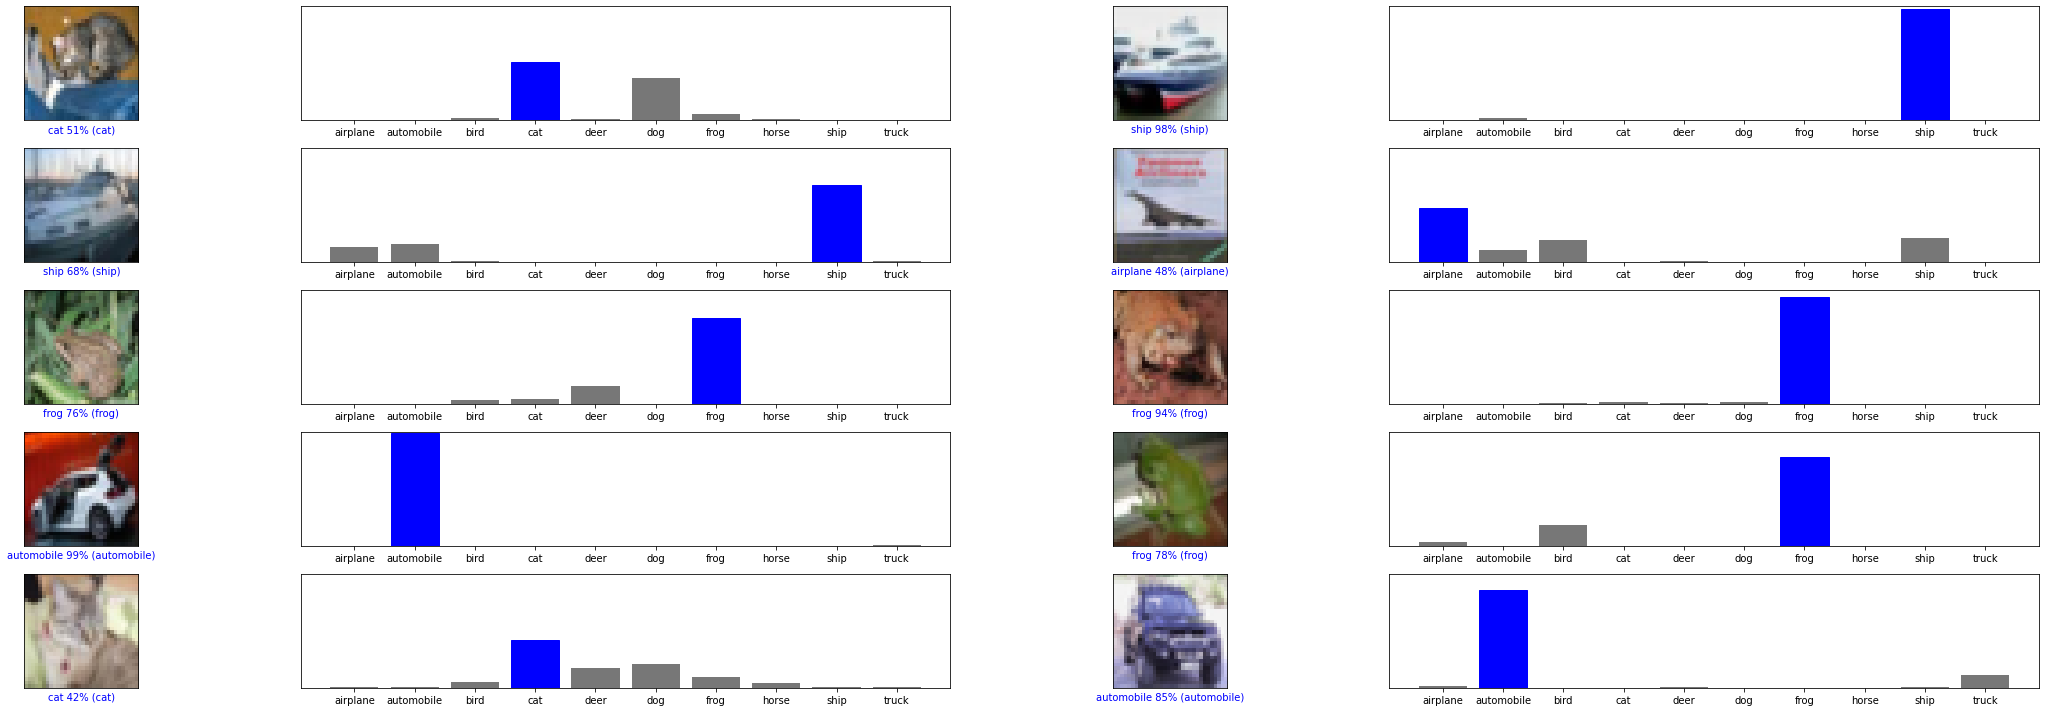

In [26]:
# визуализация результатов
num_rows = 5
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*8*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], np.argmax(y_test, axis=-1), x_test, label_names)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)  
  plot_value_array(i, predictions[i], np.argmax(y_test, axis=-1), len(label_names))
  _ = plt.xticks(range(10), label_names, rotation=0) 

plt.tight_layout()

plt.show()

### **Вывод:**

**Accuracy начальной модели:**
  - на трейне <font color='red'>**0.4578**</font>
  - на тесте <font color='red'>**0.5093**</font>
---
 1. Уменьшим последний дропаут: Dropout(0.25).
  
  **Accuracy:**
  - на трейне **0.4785**
  - на тесте **0.5111**

 Точность увеличилась.
---
 2. Заменим размер ядра пулинг слоя: pool_size=(3, 3).
  
  **Accuracy:**
  - на трейне **0.3732**
  - на тесте **0.4234**
  
  Точность снизилась.
---
 3. Заменим размер ядра пулинг слоя: pool_size=(1, 1).
  
  **Accuracy:**
  - на трейне **0.5372**
  - на тесте **0.5578**
  
  Точность увеличилась.
---
 4. Добавим в пулинг слой шаг: strides=(2, 2).
  
  **Accuracy:**
  - на трейне **0.4641**
  - на тесте **0.5195**
  
  Точность увеличилась.
---
 5. Добавим еще слой свертки со следующими параметрами:

 - model.add(Conv2D(128, (3, 3)))
 - model.add(Activation('relu'))
 - model.add(Conv2D(128, (3, 3)))
 - model.add(Activation('relu'))
 - model.add(MaxPooling2D(pool_size=(2, 2)))
 - model.add(Dropout(0.25))
  
  **Accuracy:**
  - на трейне **0.3879**
  - на тесте **0.4402**
  
  Точность снизилась.
---
 6. Уберем дропаут из слоев свертки.
  
  **Accuracy:**
  - на трейне **0.4800**
  - на тесте **0.5388**
  
  Точность увеличилась.
---
 7. Заменим функцию активации на 'tanh'.
  
  **Accuracy:**
  - на трейне **0.4864**
  - на тесте **0.5037**
  
  Точность увеличилась на трейне и снизилась на тесте.
---
 8. Уберем один слой свертки.
  
  **Accuracy:**
  - на трейне **0.5085**
  - на тесте **0.5608**
  
  Точность увеличилась.
---
 9. Увеличим ядро свертки первого слоя: Conv2D(32, (4, 4)).
  
  **Accuracy:**
  - на трейне **0.4493**
  - на тесте **0.4870**
  
  Точность снизилась.
---
 10. Уменьшим ядро свертки первого слоя: Conv2D(32, (2, 2)).
  
  **Accuracy:**
  - на трейне **0.4439**
  - на тесте **0.4936**
  
  Точность снизилась.
---
 11. Увеличим learning_rate: learning_rate=0.001.
  
  **Accuracy:**
  - на трейне **0.6288**
  - на тесте **0.6789**
  
  Точность увеличилась.
---
 12. Увеличим количество эпох: epochs=10.
  
  **Accuracy:**
  - на трейне **0.5400**
  - на тесте **0.6054**
  
  Точность увеличилась.
---
 13. Скомбинируем предыдущие параметры: уберем один слой свертки, увеличим learning_rate, снизим последний дропаут и увеличим количество эпох.
  
  **Accuracy:**
  - на трейне **0.6985**
  - на тесте **0.7261**
  
  Получился неплохой прирост точности.

**Accuracy финальной модели:**
  - на трейне <font color='lightseagreen'>**0.6985**</font>
  - на тесте <font color='lightseagreen'>**0.7261**</font>

Некоторые наблюдения:
 - Точность повышается при увеличении таких параметров как: learning_rate, количество эпох.
 - Точность повышается при уменьшении таких параметров как: Dropout, пулинг ядра, количество слоев свертки.
 - Вариации с размером ядра слоя сверки как в меньшую, так и в большую сторону ухудшили результат, поэтому однозначно зависимость определить не получилось.
 - Комбинирование параметров, которые увеличивают точность по отдельности, дали ощутимый прирост метрики.




  

### **2. Датасеты: MNIST, CIFAR100 и IMAGENET**

**MNIST**

Yann LeCun

http://yann.lecun.com/exdb/mnist/

Набор данных изображений рукописного написания цифр размером 28x28. Он содержит 60 000 обучающих и 10 000 тестовых примеров. MNIST - подмножество более крупного набора NIST, где изображения были черно-белые размером 20x20. Для набора MNIST изображения были нормализированы и приведены к серому полутоновому отображению. Классы: цифры от 0 до 9.

**Что изменить:** поменять размер входных данных, возможно убрать свертку, так как датасет небольшой, или попробовать с ней, снизить количество нейронов в полносвязных слоях и количество эпох, попробовать другой оптимизатор.

**CIFAR100**

Alex Krizhevsky

http://www.cs.toronto.edu/~kriz/cifar.html

Набор данных цветных изображений размером 32x32. Он содержит 100 классов по 600 изображений в каждом: 500 обучающих и 100 тестовых изображений. Классы сгруппированы в 20 суперклассов по 5 классов в каждом. Каждое изображение имеет метку «fine» (метка класса) и метку «coarse» (метка суперкласса). 

Список классов CIFAR100:

**Superclass**:	Classes
1. **aquatic mammals**:	beaver, dolphin, otter, seal, whale
1. **fish**:	aquarium fish, flatfish, ray, shark, trout
1. **flowers**:	orchids, poppies, roses, sunflowers, tulips
1. **food containers**:	bottles, bowls, cans, cups, plates
1. **fruit: and vegetables**	apples, mushrooms, oranges, pears, sweet peppers
1. **household electrical devices**:	clock, computer keyboard, lamp, telephone, television
1. **household furniture**:	bed, chair, couch, table, wardrobe
1. **insects**:	bee, beetle, butterfly, caterpillar, cockroach
1. **large carnivores**:	bear, leopard, lion, tiger, wolf
1. **large man-made outdoor things**:	bridge, castle, house, road, skyscraper
1. **large natural outdoor scenes**:	cloud, forest, mountain, plain, sea
1. **large omnivores and herbivores**:	camel, cattle, chimpanzee, elephant, kangaroo
1. **medium-sized mammals**:	fox, porcupine, possum, raccoon, skunk
1. **non-insect invertebrates**:	crab, lobster, snail, spider, worm
1. **people**:	baby, boy, girl, man, woman
1. **reptiles**:	crocodile, dinosaur, lizard, snake, turtle
1. **small mammals**:	hamster, mouse, rabbit, shrew, squirrel
1. **trees**:	maple, oak, palm, pine, willow
1. **vehicles 1**:	bicycle, bus, motorcycle, pickup truck, train
1. **vehicles 2**:	lawn-mower, rocket, streetcar, tank, tractor

**Что изменить:** нужно выбрать на каких метках мы будем обучаться, на метках класса или метках суперкласса, увечилить количество сверточных слоев и количество нейронов в полносвязных слоях, попробовать изменить learning_rate.

**IMAGENET**

https://image-net.org/index.php

База данных изображений, организованная в соответствии с иерархией WordNet (только существительные), в которой каждый узел иерархии соответствует тысячам изображений. Размер изображений не регламентируется.

В базе содержится 14 197 122 изображений, 21 841 проиндексированных синсетов.

**WordNet** представляет собой большую лексическую базу данных английского языка. Существительные, глаголы, прилагательные и наречия сгруппированы в наборы когнитивных синонимов (синсетов), каждый из которых выражает отдельное понятие. Синсеты связаны между собой посредством понятийно-семантических и лексических отношений.

Наиболее часто используемым подмножеством ImageNet является набор данных классификации и локализации изображений ImageNet Large Scale Visual Recognition Challenge (**ILSVRC**) 2012–2017 годов. Этот набор данных охватывает 1 000 классов объектов и содержит 1 281 167 тренировочных, 50 000 валидационных и 100 000 тестовых изображений. Это подмножество доступно на [Kaggle](https://www.kaggle.com/c/imagenet-object-localization-challenge/overview/description).

**Что изменить:** предобработать размер изображений (например сделать их 256х256), нормализовать данные, поменять размер входных данных в input, увечилить количество сверточных слоев и фильтров, попробовать увеличить количество полносвязных слоев и количество нейронов в них, добавить слои по обработке текста (синсетов).